In [1]:
import netCDF4
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import copy

In [2]:
data = netCDF4.Dataset('./narrOps_200902.nc')

In [3]:
var = ['air', 'shum', 'hgt', 'uwnd', 'vwnd']

In [4]:
x = np.ma.zeros((224,5,277,349))

In [5]:
for i,v in enumerate(var):
    x[:,i] = data.variables[v][:,0]

In [6]:
gt_data = netCDF4.Dataset('./fuzzyCodsus_200902.nc')

In [7]:
y = gt_data.variables['front_images'][:,:,::-1,:]

In [8]:
mask = y.mask

In [9]:
y = np.asarray(y) / 255

In [10]:
#shuffle data
inds = np.arange(x.shape[0])

rng = np.random.RandomState(4)

rng.shuffle(inds)

x= x[inds]
y = y[inds]


In [66]:
# separate into train and val


trind = int(0.8*len(inds))

x_tr, y_tr = x[:trind], y[:trind]
x_val, y_val = x[trind:],y[trind:]

In [67]:
means = [x_tr[:,v].mean() for v in range(len(var))]


In [11]:
means

[279.17416994325055,
 0.0066987860160444305,
 136.79813774381631,
 -0.4243838770905371,
 -0.69902369588093016]

In [68]:
for v in range(len(var)):
    x_tr[:,v] -= means[v]

/Users/racah/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  from ipykernel import kernelapp as app


In [69]:
stds = [x_tr[:,v].std() for v in range(len(var))]

In [70]:
for v in range(len(var)):
    x_tr[:,v] /= stds[v]

In [71]:
np.std(x_tr[:,1])

0.99999999999999978

In [97]:
x_mask = x_tr.mask

In [98]:
x_tr = np.asarray(x_tr)

In [99]:
x_tr[x_mask] = 0

In [119]:
x_tr.shape

(179, 5, 277, 349)

In [120]:
import keras

In [121]:
from keras.models import Sequential

In [139]:
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

In [140]:
from keras.optimizers import SGD

In [190]:
from theano import tensor as T

In [141]:
base_filters = 10

In [192]:
model = Sequential()
input_kwargs = dict(input_shape=x_tr.shape[1:], padding=(2,2))
num_layers = 3
for i in range(num_layers):
    model.add(ZeroPadding2D(**input_kwargs))
    input_kwargs=dict(padding=(2,2))
    if i == num_layers - 1:
        model.add(Convolution2D(nb_filter=5, nb_col=5, nb_row=5,activation='sigmoid'))
    else:
        model.add(Convolution2D(nb_filter=10, nb_col=5, nb_row=5, activation='relu'))


In [193]:
model.compile(loss=weighted_mse, optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))

In [194]:
model.fit(x_tr, y_tr, nb_epoch=5, batch_size=32)

Epoch 1/5
179/179 [==============================] - 79s - loss: 1.1450    
Epoch 2/5
179/179 [==============================] - 77s - loss: 0.7569    
Epoch 3/5
179/179 [==============================] - 79s - loss: 0.7324    
Epoch 4/5
179/179 [==============================] - 79s - loss: 0.7166    
Epoch 5/5
179/179 [==============================] - 78s - loss: 0.6991    


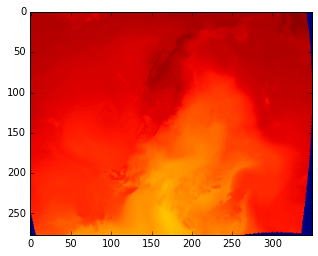

In [195]:
plt.imshow(x_tr[0,0])

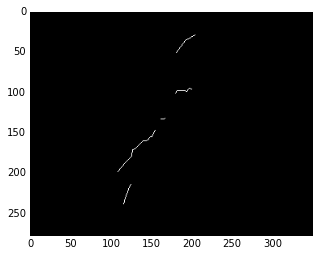

In [196]:
plt.imshow(y_tr[0,2], cmap='gray')

In [179]:
preds = model.predict(x_tr[:5])

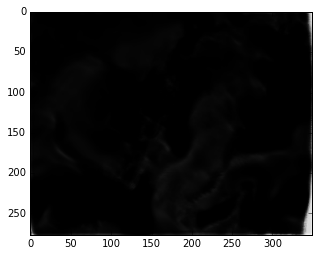

In [198]:
plt.imshow(preds[0,1], cmap='gray')

In [201]:
def weighted_mse(y_true, y_pred):
    y_w = (y_true * 2000) + 1
    return T.mean(T.square((y_pred - y_true)*y_w), axis=-1)

In [200]:
y_tr.sum() / np.product(y_tr.shape)

0.0016738452562566647